<a href="https://colab.research.google.com/github/omiyawaki/miyawaki-2025-nonmonotonic-moist-adiabat/blob/main/Figure_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[2025-08-03 17:50:12] Starting buoyancy decomposition plot generation...
[2025-08-03 17:50:12] Processing Ts = 280.0 K...
[2025-08-03 17:50:12] Processing Ts = 281.0 K...
[2025-08-03 17:50:12] Processing Ts = 282.0 K...
[2025-08-03 17:50:12] Processing Ts = 283.0 K...
[2025-08-03 17:50:12] Processing Ts = 284.0 K...
[2025-08-03 17:50:12] Processing Ts = 285.0 K...
[2025-08-03 17:50:12] Processing Ts = 286.0 K...
[2025-08-03 17:50:12] Processing Ts = 287.0 K...
[2025-08-03 17:50:12] Processing Ts = 288.0 K...
[2025-08-03 17:50:12] Processing Ts = 289.0 K...
[2025-08-03 17:50:12] Processing Ts = 290.0 K...
[2025-08-03 17:50:12] Processing Ts = 291.0 K...
[2025-08-03 17:50:12] Processing Ts = 292.0 K...
[2025-08-03 17:50:12] Processing Ts = 293.0 K...
[2025-08-03 17:50:12] Processing Ts = 294.0 K...
[2025-08-03 17:50:12] Processing Ts = 295.0 K...
[2025-08-03 17:50:12] Processing Ts = 296.0 K...
[2025-08-03 17:50:12] Processing Ts = 297.0 K...
[2025-08-03 17:50:12] Processing Ts = 298.0 K

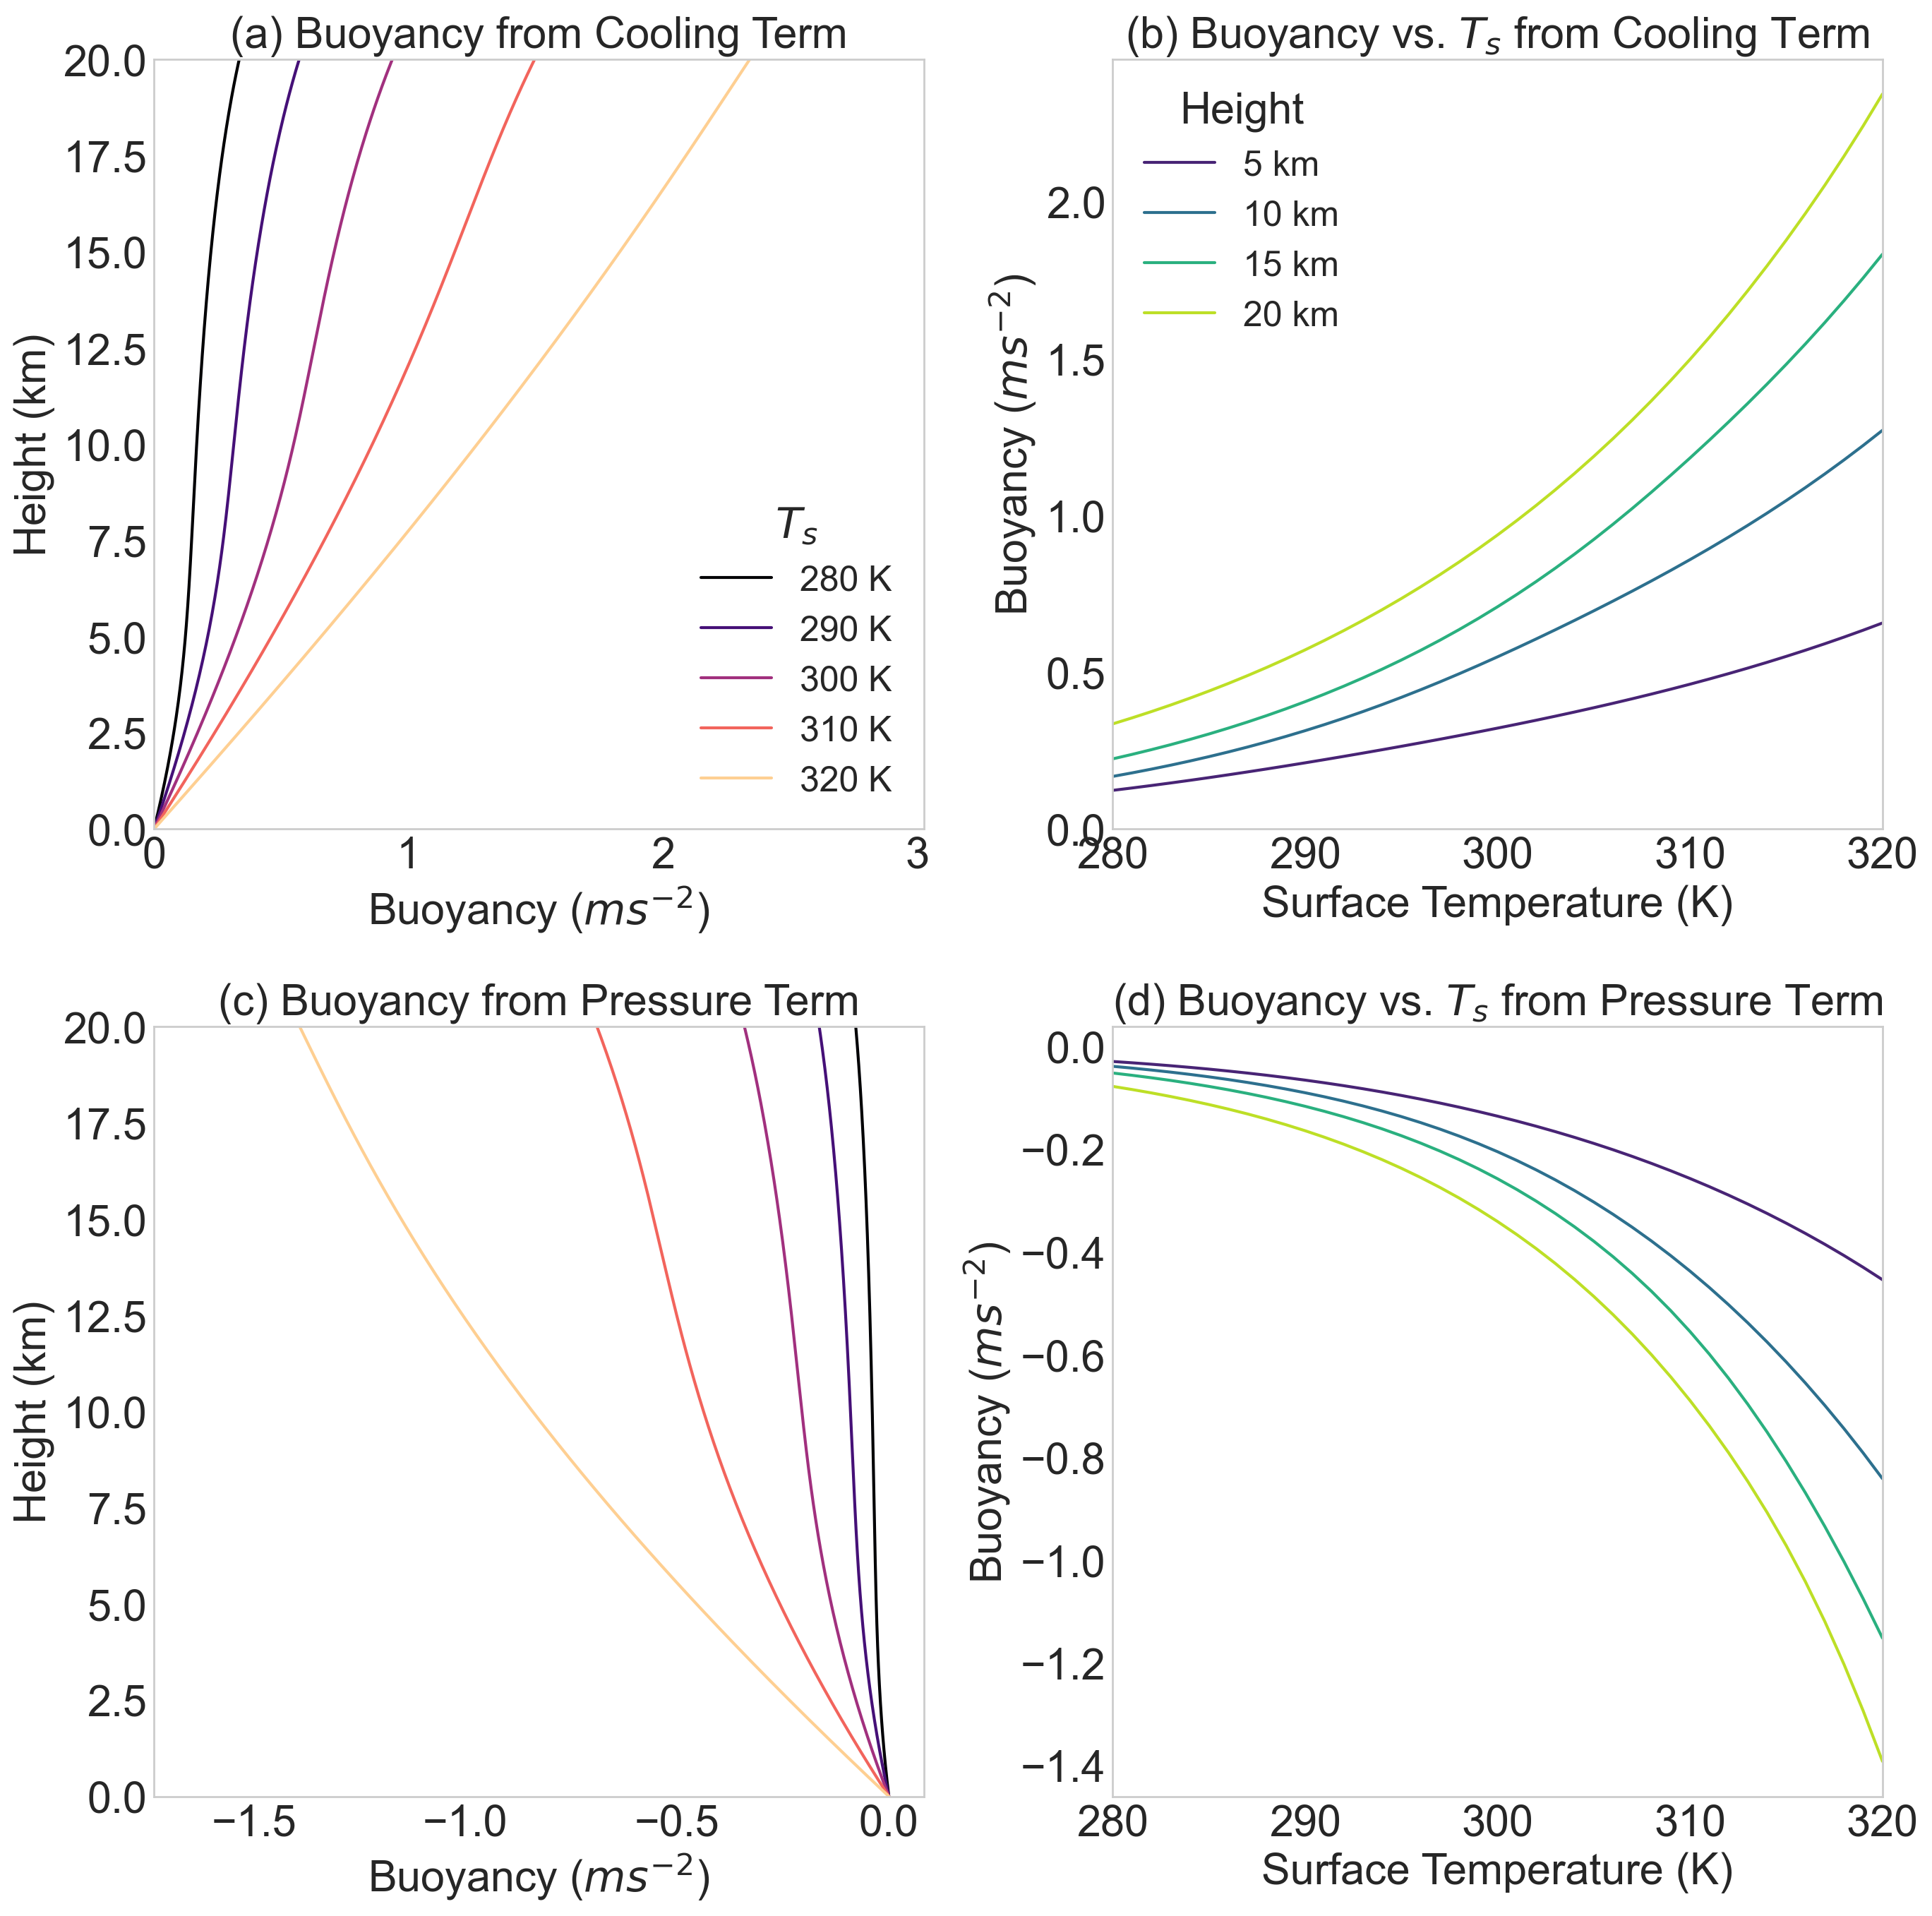

Figure 6 saved as fig-6.png


In [1]:
# ==============================================================================
# SCRIPT TO CREATE FIGURE 6:
# DECOMPOSITION OF THE BUOYANCY PROFILE
#
# This script decomposes the total buoyancy profile into contributions from the
# "Cooling Term" and "Pressure Term" of the vertical moisture gradient.
# It is analogous to Figure 3, but for buoyancy instead of warming.
#
# The script performs the following actions:
# 1. For a range of Ts, it calculates the profiles of the Cooling Component
#    and Pressure Component of the moisture gradient, dqs/dz.
# 2. It computes the vertical integral of each of these components to find
#    their respective contributions to the total buoyancy.
# 3. Finally, it generates a 2x2 line plot showing:
#    (a,b) Buoyancy from the Cooling Term (profiles and vs. Ts).
#    (c,d) Buoyancy from the Pressure Term (profiles and vs. Ts).
# ==============================================================================

# For sharper inline plots in Jupyter environments
try:
    get_ipython().run_line_magic('config', "InlineBackend.figure_format = 'retina'")
except (NameError, AttributeError):
    pass

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import root_scalar
from scipy import constants
from scipy.interpolate import interp1d
from scipy.integrate import cumulative_trapezoid
import time

# --- Physical Constants and Model Parameters ---
g = constants.g
cpd = 1005.7
Rd = 287.05
Rv = 461.5
epsilon = Rd / Rv
Lv_const = 2.501e6
A_ENTRAIN = 0.2  # Dimensionless entrainment parameter 'a'

# --- Core Thermodynamic & Profile Functions (Reused) ---
def saturation_vapor_pressure(T):
    T_celsius = T - 273.15
    es_hPa = 6.112 * np.exp((17.67 * T_celsius) / (T_celsius + 243.5))
    return es_hPa * 100.0

def saturation_specific_humidity(p, T):
    es = saturation_vapor_pressure(T)
    es = np.minimum(es, p * 0.99)
    denominator = p - (1.0 - epsilon) * es
    denominator = np.maximum(denominator, 1e-3)
    qs = epsilon * es / denominator
    return np.maximum(qs, 0.0)

def dq_dT_p(p, T):
    delta_T = 0.01
    return (saturation_specific_humidity(p, T + delta_T) - saturation_specific_humidity(p, T - delta_T)) / (2 * delta_T)

def dq_dp_T(p, T):
    delta_p = 10.0
    return (saturation_specific_humidity(p + delta_p, T) - saturation_specific_humidity(p - delta_p, T)) / (2 * delta_p)

def calculate_entraining_mse(T, p, z, a):
    qs = saturation_specific_humidity(p, T)
    return cpd * T + g * z + Lv_const * qs / (1 + a)

def calculate_moist_adiabatic_profile(T_surf, p_surf, z_max, dz, a):
    n_steps = int(z_max / dz) + 1
    z_profile = np.linspace(0, z_max, n_steps)
    T_profile, p_profile = np.full(n_steps, np.nan), np.full(n_steps, np.nan)
    T_profile[0], p_profile[0] = T_surf, p_surf
    mse_conserved = calculate_entraining_mse(T_profile[0], p_profile[0], 0.0, a)
    for i in range(n_steps - 1):
        z_c, T_c, p_c = z_profile[i], T_profile[i], p_profile[i]
        if np.isnan(T_c) or p_c <= 0: break
        z_n = z_profile[i+1]
        Tv_c = T_c * (1 + (1/epsilon - 1) * saturation_specific_humidity(p_c, T_c))
        H = (Rd * Tv_c) / g
        p_n = p_c * np.exp(-dz / H)
        if p_n <= 0: break
        try:
            sol = root_scalar(lambda T_g: calculate_entraining_mse(T_g, p_n, z_n, a) - mse_conserved, bracket=[50.0, T_c + 5], method='brentq')
            if sol.converged: T_profile[i+1], p_profile[i+1] = sol.root, p_n
            else: break
        except (ValueError, RuntimeError): break
    valid = ~np.isnan(T_profile)
    return z_profile[valid], T_profile[valid], p_profile[valid]

def main():
    """Main function to execute the calculation and plotting."""
    print(f"[{time.strftime('%Y-%m-%d %H:%M:%S')}] Starting buoyancy decomposition plot generation...")

    # --- Parameters ---
    P_SURFACE_PA = 100000.0
    Z_MAX_M = 25000
    DZ_M = 100
    T_surf_range_K = np.arange(280, 320.1, 1.0)
    z_grid_m = np.arange(0, Z_MAX_M + DZ_M, DZ_M)
    z_grid_km = z_grid_m / 1000.0

    # --- Initialize Grids ---
    cooling_comp_grid = np.full((len(z_grid_m), len(T_surf_range_K)), np.nan)
    pressure_comp_grid = np.full((len(z_grid_m), len(T_surf_range_K)), np.nan)
    t_env_master_grid = np.full_like(cooling_comp_grid, np.nan)


    # --- Calculation Loop ---
    for i, t_surf in enumerate(T_surf_range_K):
        print(f"[{time.strftime('%Y-%m-%d %H:%M:%S')}] Processing Ts = {t_surf:.1f} K...")
        z_env, t_env, p_env = calculate_moist_adiabatic_profile(t_surf, P_SURFACE_PA, Z_MAX_M, DZ_M, a=A_ENTRAIN)
        if len(z_env) < 2: continue

        interp_t_env = interp1d(z_env, t_env, bounds_error=False, fill_value=np.nan)
        interp_p_env = interp1d(z_env, p_env, bounds_error=False, fill_value=np.nan)
        t_env_grid = interp_t_env(z_grid_m)
        p_env_grid = interp_p_env(z_grid_m)

        t_env_master_grid[:, i] = t_env_grid

        gamma_m_grid = -np.gradient(t_env_grid, DZ_M)
        rho_grid = p_env_grid / (Rd * t_env_grid)

        cooling_comp_grid[:, i] = -gamma_m_grid * dq_dT_p(p_env_grid, t_env_grid)
        pressure_comp_grid[:, i] = -rho_grid * g * dq_dp_T(p_env_grid, t_env_grid)

    # --- Integrate to get buoyancy contributions ---
    prefactor_const = (A_ENTRAIN / (1 + A_ENTRAIN)) * (Lv_const / cpd)

    buoyancy_from_cooling = -(g / t_env_master_grid) * prefactor_const * cumulative_trapezoid(cooling_comp_grid, z_grid_m, axis=0, initial=0)
    buoyancy_from_pressure = -(g / t_env_master_grid) * prefactor_const * cumulative_trapezoid(pressure_comp_grid, z_grid_m, axis=0, initial=0)


    # --- Visualization ---
    print(f"[{time.strftime('%Y-%m-%d %H:%M:%S')}] Calculation complete. Generating plot...")
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, axes = plt.subplots(2, 2, figsize=(14, 14))
    base_fontsize = 22

    # --- Row 1: Cooling Term ---
    ax_cool_prof, ax_cool_alt = axes[0, 0], axes[0, 1]
    ax_cool_prof.set_title('(a) Buoyancy from Cooling Term', fontsize=base_fontsize)
    ax_cool_alt.set_title('(b) Buoyancy vs. $T_{s}$ from Cooling Term', fontsize=base_fontsize)

    T_plot_values = np.arange(280, 320.1, 10.0)
    cmap_profiles = plt.get_cmap('magma')
    colors_profiles = cmap_profiles(np.linspace(0, 0.9, len(T_plot_values)))

    for i, t_val in enumerate(T_plot_values):
        t_idx = np.argmin(np.abs(T_surf_range_K - t_val))
        ax_cool_prof.plot(buoyancy_from_cooling[:, t_idx], z_grid_km, color=colors_profiles[i], label=f'{int(t_val)} K')

    z_levels_km = [5, 10, 15, 20]
    cmap_altitudes = plt.get_cmap('viridis')
    colors_altitudes = cmap_altitudes(np.linspace(0.1, 0.9, len(z_levels_km)))
    for i, z_km in enumerate(z_levels_km):
        z_idx = np.argmin(np.abs(z_grid_km - z_km))
        ax_cool_alt.plot(T_surf_range_K, buoyancy_from_cooling[z_idx, :], color=colors_altitudes[i], label=f'{z_km} km')

    # --- Row 2: Pressure Term ---
    ax_pres_prof, ax_pres_alt = axes[1, 0], axes[1, 1]
    ax_pres_prof.set_title('(c) Buoyancy from Pressure Term', fontsize=base_fontsize)
    ax_pres_alt.set_title('(d) Buoyancy vs. $T_{s}$ from Pressure Term', fontsize=base_fontsize)

    for i, t_val in enumerate(T_plot_values):
        t_idx = np.argmin(np.abs(T_surf_range_K - t_val))
        ax_pres_prof.plot(buoyancy_from_pressure[:, t_idx], z_grid_km, color=colors_profiles[i], label=f'{int(t_val)} K')

    for i, z_km in enumerate(z_levels_km):
        z_idx = np.argmin(np.abs(z_grid_km - z_km))
        ax_pres_alt.plot(T_surf_range_K, buoyancy_from_pressure[z_idx, :], color=colors_altitudes[i], label=f'{z_km} km')

    # --- Formatting and Labels ---
    ax_cool_prof.legend(title='$T_{s}$', title_fontsize=base_fontsize, fontsize=base_fontsize - 4)
    ax_cool_alt.legend(title='Height', title_fontsize=base_fontsize, fontsize=base_fontsize - 4)

    # Set labels for all axes
    axes[0,0].set_ylabel('Height (km)', fontsize=base_fontsize)
    axes[1,0].set_ylabel('Height (km)', fontsize=base_fontsize)
    axes[0,1].set_ylabel('Buoyancy ($m s^{-2}$)', fontsize=base_fontsize)
    axes[1,1].set_ylabel('Buoyancy ($m s^{-2}$)', fontsize=base_fontsize)

    axes[0,0].set_xlabel('Buoyancy ($m s^{-2}$)', fontsize=base_fontsize)
    axes[1,0].set_xlabel('Buoyancy ($m s^{-2}$)', fontsize=base_fontsize)
    axes[0,1].set_xlabel('Surface Temperature (K)', fontsize=base_fontsize)
    axes[1,1].set_xlabel('Surface Temperature (K)', fontsize=base_fontsize)

    # Apply settings to all axes
    for ax in axes.flatten():
        ax.tick_params(axis='both', which='major', labelsize=base_fontsize)
        ax.grid(False)
        ax.set_box_aspect(1)

    # Set axis limits
    axes[0,0].set_ylim(0, 20)
    axes[1,0].set_ylim(0, 20)
    axes[0,1].set_xlim(280, 320)
    axes[1,1].set_xlim(280, 320)
    ax_cool_prof.set_xlim(left=0) # Cooling term buoyancy is positive
    ax_cool_alt.set_ylim(bottom=0)

    plt.tight_layout(pad=2.0)
    fig6_filename = "fig-6.png"
    plt.savefig(fig6_filename, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"Figure 6 saved as {fig6_filename}")

if __name__ == '__main__':
    main()
